In [3]:
import sys
import os
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

sys.path.append(os.path.abspath(os.path.join("..", "src")))
import dataset
from models import SimpleSRModel, get_y_tensors
import utils
import metrics

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
ds = dataset.load_general100_dataset()

### Dataset tests

In [3]:
print(ds["train"])

Dataset({
    features: ['image'],
    num_rows: 900
})


In [4]:
img = ds["train"][11]["image"]

pene = dataset.augment_data([img])

20


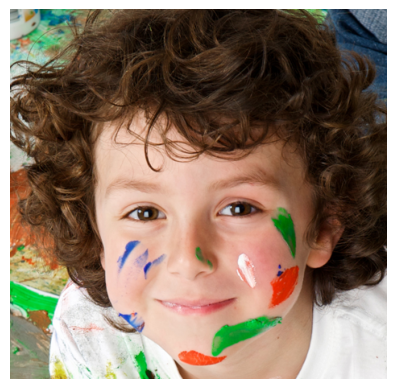

(468, 460)


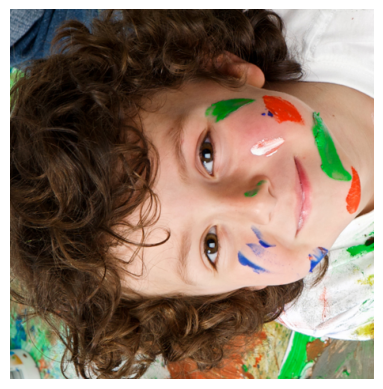

(460, 468)


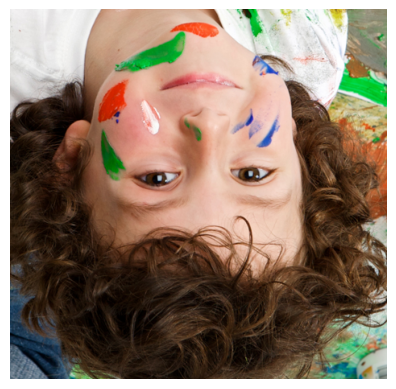

(468, 460)


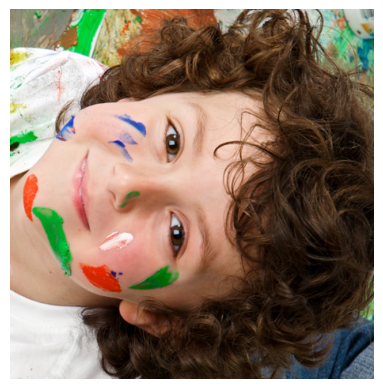

(460, 468)


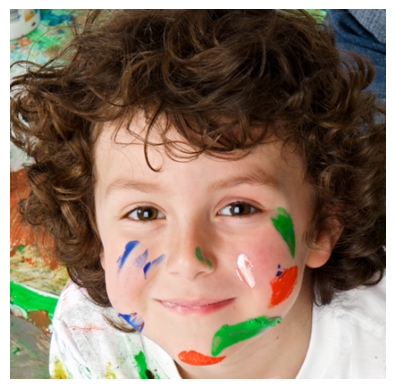

(421, 414)


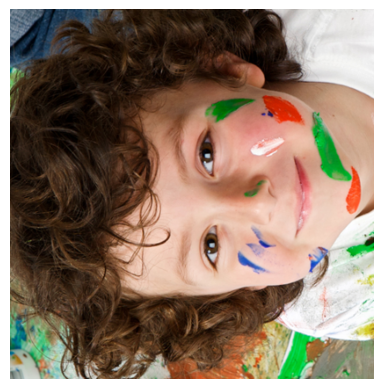

(414, 421)


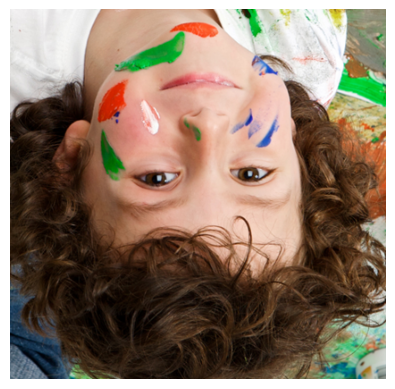

(421, 414)


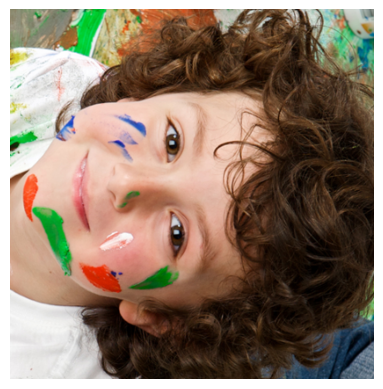

(414, 421)


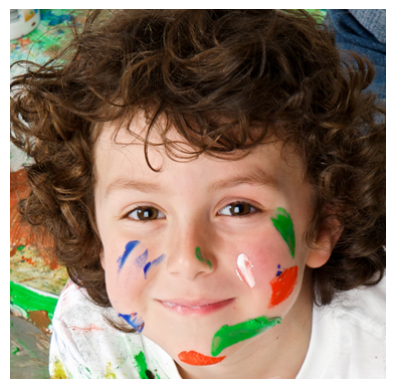

(374, 368)


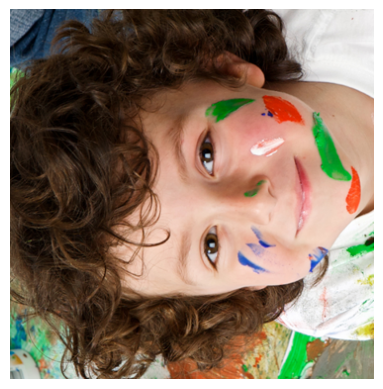

(368, 374)


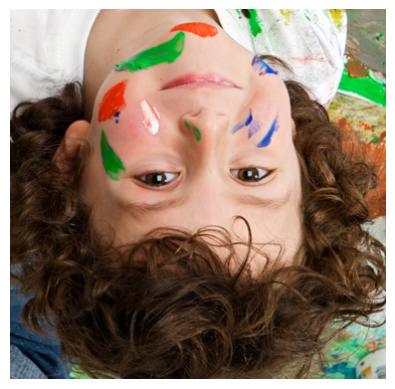

(374, 368)


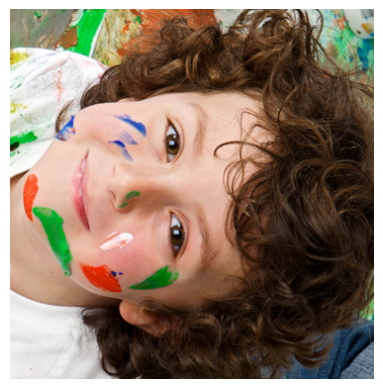

(368, 374)


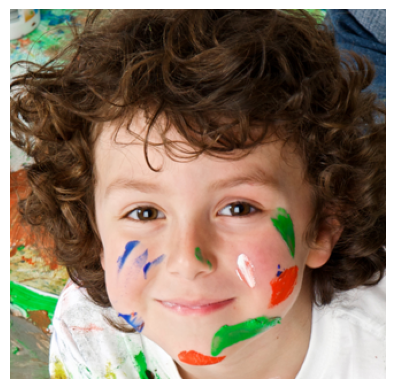

(327, 322)


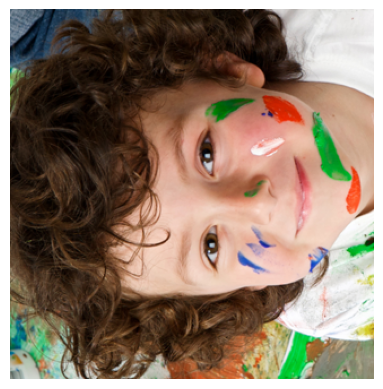

(322, 327)


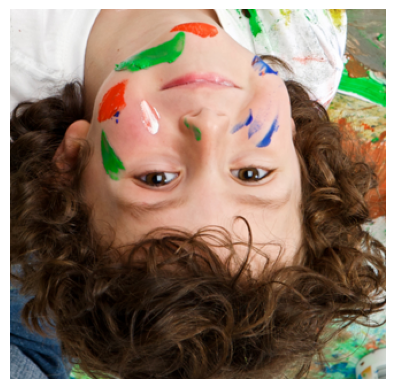

(327, 322)


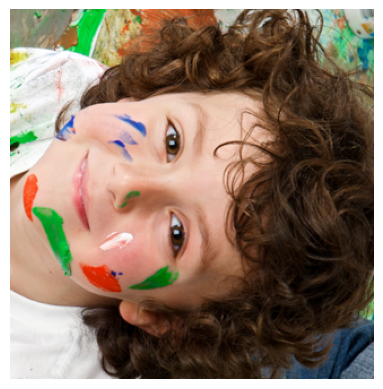

(322, 327)


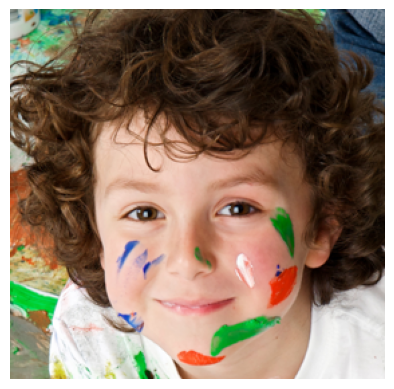

(280, 276)


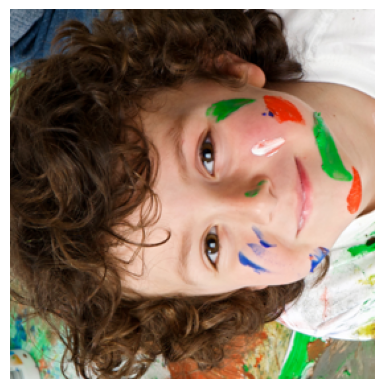

(276, 280)


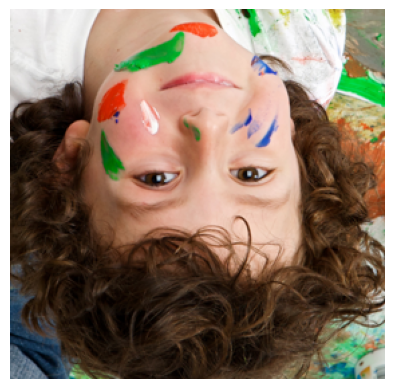

(280, 276)


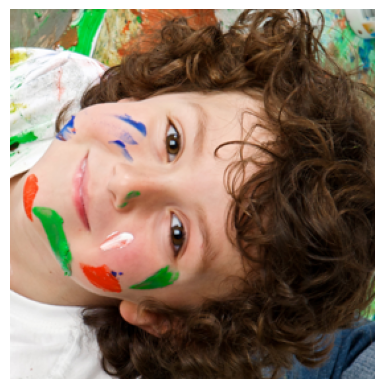

(276, 280)


In [5]:
print(len(pene))
for p in pene:
    plt.imshow(p)
    plt.axis("off")
    plt.show()
    print(p.size)

In [6]:
sample = pene[0]
penes_mejores = dataset.prepare_patches([sample], 2, (10, 10), 5, True)

Number of images: 2025


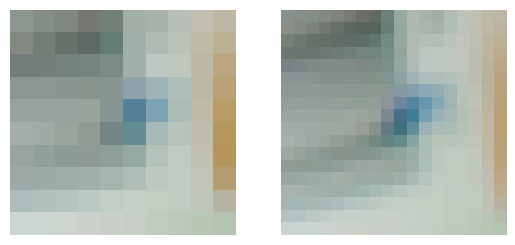

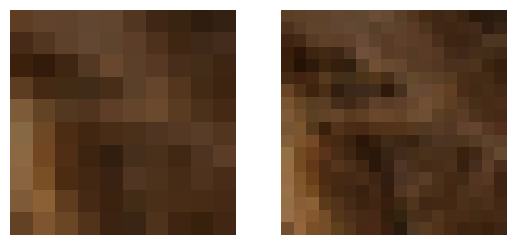

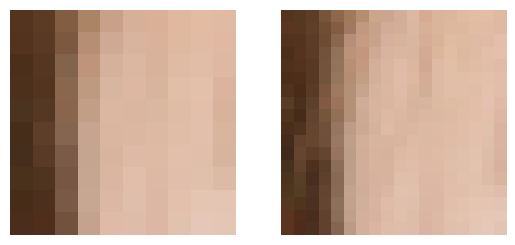

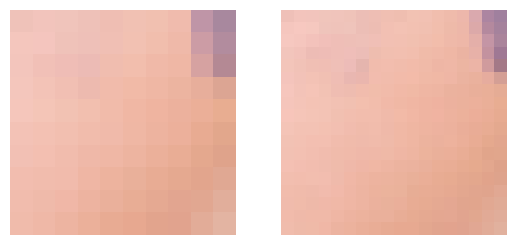

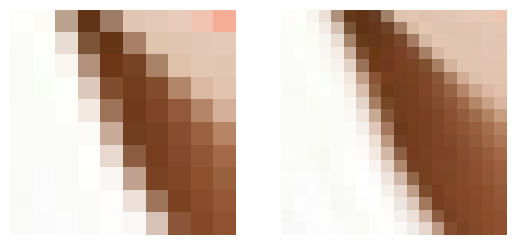

In [7]:
print("Number of images:", len(penes_mejores))
for i in range(0, len(penes_mejores), 500):
    immg0, immg1 = penes_mejores[i]
    plt.subplot(1, 2, 1)
    plt.imshow(immg0)
    plt.axis("off")
    plt.subplot(1, 2, 2)
    plt.imshow(immg1)
    plt.axis("off")
    plt.show()

### Dataset augmentation and patching

In [8]:
img_arr = [] # collect all images from ds into img_arr
for img in ds["train"]:
    img_arr.append(img["image"])

In [9]:
img_sample = img_arr[:100]
args_augment = [[0.9, 0.8, 0.7], [90, 180, 270]]
args_patches = [2, (10, 10), 5, True]
result = dataset.get_dataset(img_sample, args_augment, args_patches)

In [10]:
sr_dataset = dataset.SRTensorDataset(result)

In [11]:
print("Number of images in SRTensorDataset:", len(sr_dataset))
print("First image shape:", sr_dataset[0][0].shape)
print("Type del dataloader", type(sr_dataset))
print("Type de cada elemento del dataloader", type(sr_dataset[0]))
print("First image type:", type(sr_dataset[0][0]))

Number of images in SRTensorDataset: 1966840
First image shape: torch.Size([1, 10, 10])
Type del dataloader <class 'dataset.SRTensorDataset'>
Type de cada elemento del dataloader <class 'tuple'>
First image type: <class 'torch.Tensor'>


### Model training

In [12]:
train_loader, val_loader = dataset.train_val_dataloaders(sr_dataset, batch_size=2, num_workers=0, seed=42, val_split=0.2)

Dataset Statistics:

Total samples: 1966840
Training examples: 1573472
Validation examples: 393368
Batch size: 2


In [13]:
#podemos no hacer 'sr_dataset = dataset.SRTensorDataset(result)' y tambien funciona:
train_loader, val_loader = dataset.train_val_dataloaders(result,  batch_size=2, num_workers=0, seed=42, val_split=0.2)

Dataset Statistics:

Total samples: 1966840
Training examples: 1573472
Validation examples: 393368
Batch size: 2


In [ ]:
#para srcnn no hay que recortar, por lo tanto corp tiene que ser falso
args_augment_srcnn = [[0.9, 0.8, 0.7], [90, 180, 270]]
args_patches_srcnn = [2, (10, 10), 5, False]

args_dataloaders = {
    "batch_size": 100,
    "num_workers": 0,
    "seed": 42,
    "val_split": 0.2
}
train_loader_srcnn, val_loader_srcnn = dataset.prepare_to_train(img_sample, args_augment_srcnn, args_patches_srcnn, args_dataloaders)

NameError: name 'img_sample' is not defined

In [ ]:
def train_sr_model(model, train_loader, val_loader, num_epochs=10, lr=1e-4, device=None):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    model.to(device)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
            lr_batch, hr_batch = batch
            lr_batch, hr_batch = lr_batch.to(device), hr_batch.to(device)

            # Forward
            sr_batch = model(lr_batch)

            # Loss
            loss = criterion(sr_batch, hr_batch)

            # Backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)
        print(f"[Epoch {epoch+1}] Train Loss: {avg_train_loss:.6f}")

        # VALIDACIÓN
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for val_batch in val_loader:
                lr_val, hr_val = val_batch
                lr_val, hr_val = lr_val.to(device), hr_val.to(device)

                sr_val = model(lr_val)
                loss = criterion(sr_val, hr_val)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)
        print(f"[Epoch {epoch+1}] Val Loss: {avg_val_loss:.6f}")

In [17]:
model = SimpleSRModel(upsample_factor=2)

In [18]:
train_sr_model(model, train_loader_srcnn, val_loader_srcnn, num_epochs=20, lr=1e-4)
torch.save(model.state_dict(), "modelo_final.pth")

Epoch 1/20 - Training: 100%|██████████| 15735/15735 [13:19<00:00, 19.68it/s]


[Epoch 1] Train Loss: 0.002909
[Epoch 1] Val Loss: 0.001237


Epoch 2/20 - Training: 100%|██████████| 15735/15735 [13:11<00:00, 19.88it/s]


[Epoch 2] Train Loss: 0.001225
[Epoch 2] Val Loss: 0.001215


Epoch 3/20 - Training: 100%|██████████| 15735/15735 [13:01<00:00, 20.13it/s]


[Epoch 3] Train Loss: 0.001208
[Epoch 3] Val Loss: 0.001199


Epoch 4/20 - Training: 100%|██████████| 15735/15735 [13:10<00:00, 19.91it/s]


[Epoch 4] Train Loss: 0.001198
[Epoch 4] Val Loss: 0.001193


Epoch 5/20 - Training: 100%|██████████| 15735/15735 [12:50<00:00, 20.43it/s]


[Epoch 5] Train Loss: 0.001190
[Epoch 5] Val Loss: 0.001183


Epoch 6/20 - Training: 100%|██████████| 15735/15735 [12:47<00:00, 20.51it/s]


[Epoch 6] Train Loss: 0.001184
[Epoch 6] Val Loss: 0.001177


Epoch 7/20 - Training: 100%|██████████| 15735/15735 [12:48<00:00, 20.47it/s]


[Epoch 7] Train Loss: 0.001177
[Epoch 7] Val Loss: 0.001171


Epoch 8/20 - Training: 100%|██████████| 15735/15735 [12:46<00:00, 20.53it/s]


[Epoch 8] Train Loss: 0.001170
[Epoch 8] Val Loss: 0.001166


Epoch 9/20 - Training: 100%|██████████| 15735/15735 [12:46<00:00, 20.52it/s]


[Epoch 9] Train Loss: 0.001164
[Epoch 9] Val Loss: 0.001158


Epoch 10/20 - Training: 100%|██████████| 15735/15735 [12:47<00:00, 20.50it/s]


[Epoch 10] Train Loss: 0.001158
[Epoch 10] Val Loss: 0.001154


Epoch 11/20 - Training: 100%|██████████| 15735/15735 [12:47<00:00, 20.50it/s]


[Epoch 11] Train Loss: 0.001153
[Epoch 11] Val Loss: 0.001147


Epoch 12/20 - Training: 100%|██████████| 15735/15735 [12:47<00:00, 20.51it/s]


[Epoch 12] Train Loss: 0.001149
[Epoch 12] Val Loss: 0.001144


Epoch 13/20 - Training: 100%|██████████| 15735/15735 [12:47<00:00, 20.49it/s]


[Epoch 13] Train Loss: 0.001146
[Epoch 13] Val Loss: 0.001141


Epoch 14/20 - Training: 100%|██████████| 15735/15735 [12:47<00:00, 20.50it/s]


[Epoch 14] Train Loss: 0.001143
[Epoch 14] Val Loss: 0.001138


Epoch 15/20 - Training: 100%|██████████| 15735/15735 [12:48<00:00, 20.48it/s]


[Epoch 15] Train Loss: 0.001140
[Epoch 15] Val Loss: 0.001135


Epoch 16/20 - Training: 100%|██████████| 15735/15735 [12:43<00:00, 20.62it/s]


[Epoch 16] Train Loss: 0.001136
[Epoch 16] Val Loss: 0.001132


Epoch 17/20 - Training: 100%|██████████| 15735/15735 [12:43<00:00, 20.61it/s]


[Epoch 17] Train Loss: 0.001133
[Epoch 17] Val Loss: 0.001131


Epoch 18/20 - Training: 100%|██████████| 15735/15735 [12:42<00:00, 20.63it/s]


[Epoch 18] Train Loss: 0.001130
[Epoch 18] Val Loss: 0.001126


Epoch 19/20 - Training: 100%|██████████| 15735/15735 [12:42<00:00, 20.62it/s]


[Epoch 19] Train Loss: 0.001128
[Epoch 19] Val Loss: 0.001124


Epoch 20/20 - Training: 100%|██████████| 15735/15735 [12:42<00:00, 20.64it/s]


[Epoch 20] Train Loss: 0.001125
[Epoch 20] Val Loss: 0.001124


### Model testing

In [4]:
model = SimpleSRModel(upsample_factor=2)
model.load_state_dict(torch.load("modelo_final.pth"))
model.eval()

SimpleSRModel(
  (body): Sequential(
    (0): Conv2d(1, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
    (1): PReLU(num_parameters=1)
    (2): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
    (3): PReLU(num_parameters=1)
    (4): Conv2d(32, 4, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): PixelShuffle(upscale_factor=2)
  )
)

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

factor = 2
for setnum in [5, 14]:
    ds = utils.get_images(setnum, factor)
    hr_images, lr_images = zip(*ds)
    lr_tensors = get_y_tensors(lr_images)
    hr_tensors = get_y_tensors(hr_images)

    psnrs = []
    ssims = []
    for lr, hr in zip(lr_tensors, hr_tensors):
        lr = lr.to(device)
        with torch.no_grad():
            sr = model(lr).cpu().numpy().squeeze()
            hr = hr.numpy().squeeze()

        sr = np.clip(sr, 0, 1) # probablemente introduce error, hay que ver como evitarlo

        psnrs.append(metrics.calculate_psnr(sr, hr, data_range=1.0))
        ssims.append(metrics.calculate_ssim(sr, hr, data_range=1.0))
    print(f"Dataset {setnum} - PSNR: {np.mean(psnrs):.2f}, SSIM: {np.mean(ssims):.4f}")


Dataset 5 - PSNR: 33.70, SSIM: 0.9220
Dataset 14 - PSNR: 29.94, SSIM: 0.8633
